In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np


In [2]:
engine = create_engine(
    "mysql+pymysql://root:@localhost:3306/accounting_system_myself"
)


In [3]:
suppliers = pd.read_sql("""
SELECT *
FROM suppliers su
JOIN supplier_translations sup
    ON su.id = sup.supplier_id
WHERE su.deleted_at IS NULL
  AND sup.locale = 'ar'
""", engine)



In [4]:
suppliers[['name','email','phone','image']]

,name,email,phone,image
0,مورد الأدوات المكتبية,supplier1@example.com,777111222,supplier1.jpg
1,مورد الأجهزة الإلكترونية,supplier2@example.com,777333444,supplier2.jpg
2,مورد المواد الاستهلاكية,supplier3@example.com,777555666,supplier3.jpg


In [5]:
bills = pd.read_sql("""
SELECT *
FROM bills
WHERE deleted_at IS NULL 
AND bill_type_id = 1
""", engine)

In [6]:
bills

,id,date,bill_type_id,post,note,customer_id,sale_representative_id,supplier_id,user_id,branch_id,created_at,updated_at,deleted_at
0,16,2026-01-13,1,1,sales,1,1,None,1,1,2026-01-13 10:28:54,2026-01-13 10:28:54,None


In [7]:
bill_details = pd.read_sql("""
SELECT *
FROM bill_details
WHERE deleted_at IS NULL 

""", engine)

In [8]:
data = bills.merge(bill_details, left_on="id", right_on="bill_id", how="inner")


In [9]:
data[['date','post','supplier_id','bill_type_id','note']]

,date,post,supplier_id,bill_type_id,note
0,2026-01-13,1,None,1,sales


In [10]:
# إجمالي قبل الخصم

# الخصم

# الضريبة

# الصافي النهائي

data["total_before_discount"] = data["quantity"] * data["price"]

data["discount_value"] = data["total_before_discount"] * (data["discount"] / 100)

data["total_after_discount"] = data["total_before_discount"] - data["discount_value"]

data["vat_value"] = data["total_after_discount"] * (data["VAT"] / 100)

data["final_total"] = data["total_after_discount"] + data["vat_value"]


In [11]:
# إجمالي كل فاتورة
bill_summary = data.groupby("bill_id")["final_total"].sum().reset_index()

print(bill_summary.head())


   bill_id  final_total
0       16      15000.0


In [12]:
total_purchases = data["final_total"].sum()
print("إجمالي المشتريات:", total_purchases)


إجمالي المشتريات: 15000.0


In [13]:
# أكثر مورد تم الشراء منه
supplier_analysis = data.groupby("supplier_id")["final_total"].sum().sort_values(ascending=False)

print(supplier_analysis.head())

Series([], Name: final_total, dtype: float64)


In [14]:
# أكثر منتج تم شراؤه
product_analysis = data.groupby("product_id")["quantity"].sum().sort_values(ascending=False)

print(product_analysis.head())

product_id
3    10.0
Name: quantity, dtype: float64


In [15]:
# تحليل شهري
data["date"] = pd.to_datetime(data["date"])

monthly_analysis = data.groupby(data["date"].dt.to_period("M"))["final_total"].sum()

print(monthly_analysis)


date
2026-01    15000.0
Freq: M, Name: final_total, dtype: float64


<class 'pandas.core.series.Series'>
date
2026-01-31    15000.0
Freq: ME, Name: final_total, dtype: float64


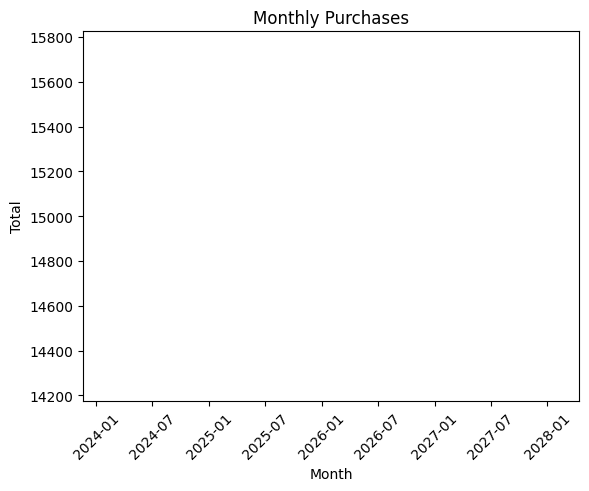

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# تحويل التاريخ
data["date"] = pd.to_datetime(data["date"], errors="coerce")

# حذف القيم الفارغة
data = data.dropna(subset=["date"])

# تحويل المبلغ لرقم
data["final_total"] = pd.to_numeric(data["final_total"], errors="coerce")
data = data.dropna(subset=["final_total"])

# التأكد من أن الفهرس تاريخ
data = data.set_index("date")

# التحليل الشهري
monthly_analysis = data.resample("ME")["final_total"].sum()

# تأكد أنه Series رقمي
monthly_analysis = monthly_analysis.astype(float)

print(type(monthly_analysis))
print(monthly_analysis.head())

# الرسم
plt.figure()
plt.plot(monthly_analysis.index, monthly_analysis.values)

plt.title("Monthly Purchases")
plt.xlabel("Month")
plt.ylabel("Total")
plt.xticks(rotation=45)

plt.show()


In [18]:
customer = pd.read_sql("""
SELECT *
FROM customers cu
JOIN customer_translations cus
    ON cu.id = cus.customer_id
WHERE cu.deleted_at IS NULL
  AND cus.locale = 'ar'
""", engine)



In [21]:
customer[['name','phone','email','debit_limit','image']]

,name,phone,email,debit_limit,image
0,شركة النجاح,777111000,customer1@example.com,500000,customer1.jpg
1,شركة المستقبل,777222000,customer2@example.com,1000000,customer2.jpg
2,مؤسسة الشروق,777333000,customer3@example.com,300000,customer3.jpg


In [23]:
sale_representatives = pd.read_sql("""
SELECT *
FROM sale_representatives sr
JOIN sale_representative_translations srt
    ON sr.id = srt.sale_representative_id
WHERE sr.deleted_at IS NULL
  AND srt.locale = 'ar'
""", engine)



In [25]:
sale_representatives[['name','phone','email','commission','image']]

,name,phone,email,commission,image
0,أحمد علي,777111900,rep1@example.com,5,rep1.jpg
1,محمد صالح,777222900,rep2@example.com,7,rep2.jpg
2,سعيد حسين,777333900,rep3@example.com,6,rep3.jpg
